# Problem Statement

Earthquakes are a common cataclysmic natural that has the potential to cause great damage and destroy everything. An earthquake is the shaking of the Earth's surface. These movements are caused by stress stress buildup along the edges of plates called tectonic plates. In addition, earthquakes can be caused by other factors including volcanic activity, landslides, and human-made events like underground or overground explosions.

Earthquake depth or also know as the Focal Depth is the area below the Earth's surface where the earthquate's rupture occurs and is very important because it has a direct affect on the intensity and location of ground shaking. The closer the originating rupture is to the surface, the closer and more damage it will cause. Therefore this project will focus on predticting the depth of a rupture given inputs. These inputs will be:
1. Magnitude
2. Latitude
3. Longitude
4. Hour
5. Day
6. Month
7. Year   

Accurately predicting the depth of an earthquake is critical for assessing its potential impact and guiding emergency response. Depth influences several key factors including surface shaking intensity, potential damage, and the risk of a tsunami. This project explores supervised regression models to predict earthquake depth using geophysical features such as magnitude, latitude, longitude, and time-based variables.

In [48]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

## Data

The Pacific Northwest Seismic Network (PNSN) is a regional seismic monitoring system designed to detect, analyze, and report on earthquake activity across the Pacific Northwest—including Washington, Oregon, and parts of northern California and southern British Columbia.

### Purpose and Mission

* Earthquake Detection: PNSN operates hundreds of seismic stations that continuously monitor ground motion to detect earthquakes in real time.
* Early Warning: It contributes to the ShakeAlert system, which can provide seconds of warning before strong shaking arrives—critical for safety and infrastructure shutdowns.
* Hazard Assessment: Supports scientific research and public agencies in understanding seismic hazards, especially in high-risk zones like the Cascadia Subduction Zone.
* Public Safety and Education: Offers data, alerts, and educational resources to help communities prepare for and respond to earthquakes.

### Who Uses PNSN Data?
* Scientists and Engineers: For modeling fault behavior, ground shaking, and infrastructure resilience.
* Emergency Managers: To coordinate response and recovery efforts.
* Public Utilities and Transit Systems: For automated shutdowns and safety protocols.
* General Public: Through apps, websites, and alert systems.

### Reference
https://www.pnsn.org/

In [49]:
# Load your dataset
df = pd.read_csv('data/earthquake_data.csv')

# Drop duplicates and handle missing values
df.drop_duplicates(inplace=True)
df.dropna(subset=['Magnitude', 'Epoch(UTC)', 'Lat', 'Lon', 'Depth Km'], inplace=True)

# Drop rows with invalid timestamps or missing depth
df = df.dropna(subset=['Depth Km', 'Epoch(UTC)', 'Lat', 'Lon', 'Magnitude'])

# Drop non-numeric or irrelevant columns
df = df.drop(columns=['Evid', 'Time Local', 'Distance From', 'Magnitude Type'])

# Convert time fields
df['Epoch(UTC)'] = pd.to_datetime(df['Epoch(UTC)'], unit='s', errors='coerce')
df['Time UTC'] = pd.to_datetime(df['Time UTC'], errors='coerce')

# Drops invalid dates from 'Time UTC' and 'Epoch(UTC)'
df = df.dropna(subset=['Time UTC', 'Epoch(UTC)'])


In [50]:
# Extract time features
df['hour'] = df['Epoch(UTC)'].dt.hour
df['day'] = df['Epoch(UTC)'].dt.day
df['month'] = df['Epoch(UTC)'].dt.month
df['year'] = df['Epoch(UTC)'].dt.year

# Define the features and the target
X = df[['Magnitude', 'Lat', 'Lon', 'hour', 'day', 'month', 'year']]
y = df['Depth Km']

## Visualize Earthquake Depth (km) before training the Models

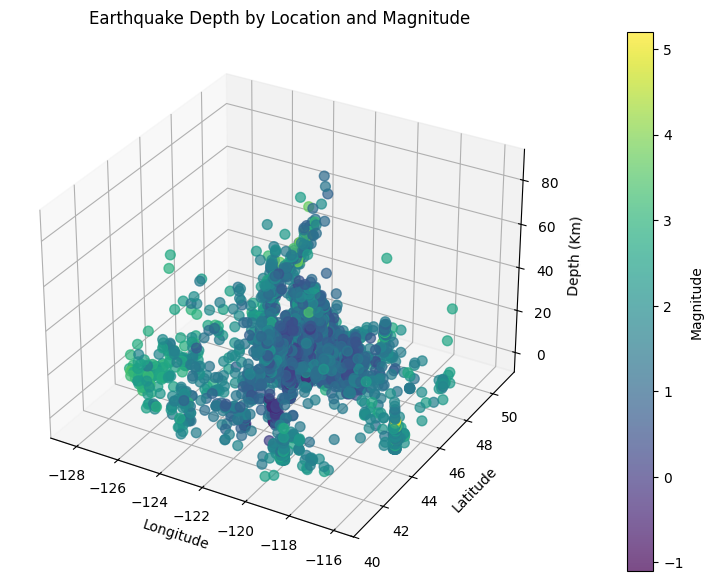

In [51]:
# Create a 3D scatter plot to visualize earthquake depth(Km) by
# magnitude, latitude, and longitude. This gives us a baseline of where
# we are starting.

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

sc = ax.scatter(df['Lon'], df['Lat'], df['Depth Km'],
                c=df['Magnitude'], cmap='viridis', s=50, alpha=0.7)

ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_zlabel("Depth (Km)")
ax.set_title("Earthquake Depth by Location and Magnitude")

# Show a colorbar for magnitude
cbar = plt.colorbar(sc, pad=0.1)
cbar.set_label("Magnitude")

plt.show()

### Train and Predict Earthquake Depth

Divides the dataset features into training and testing sets allocating 20% for test and the remaining 80% for training. This ensures the same data split is used everytime the code runs because of 'random_state=42'

In [52]:
# Train Regression Model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


### Predict and Evaluate Performance

In [53]:
# Evaluate Performance. Compare y_pred to X_test
y_pred = model.predict(X_test)

print('Earthquake Depth Based On Input Features')
print(y_pred)

print("RMSE:", root_mean_squared_error(y_test, y_pred))
print("R² Score:", r2_score(y_test, y_pred))

Earthquake Depth Based On Input Features
[6.2317212  5.25492651 7.28323577 ... 6.1437522  8.93332037 2.46520064]
RMSE: 8.14460398224119
R² Score: 0.2451539653561956


**An Explaination of the scores:**
* For RMSE of 8.14km - On average, the linear models predictions are off by about 8.14 kilometers from the true depth
* R2 Score of 0.245 - The linear model explains 24.5% of the variance in earthquake depth

### Visualizations

The Below diagram shows the predicted depth vs. actual depth for the Linear Regression Model 

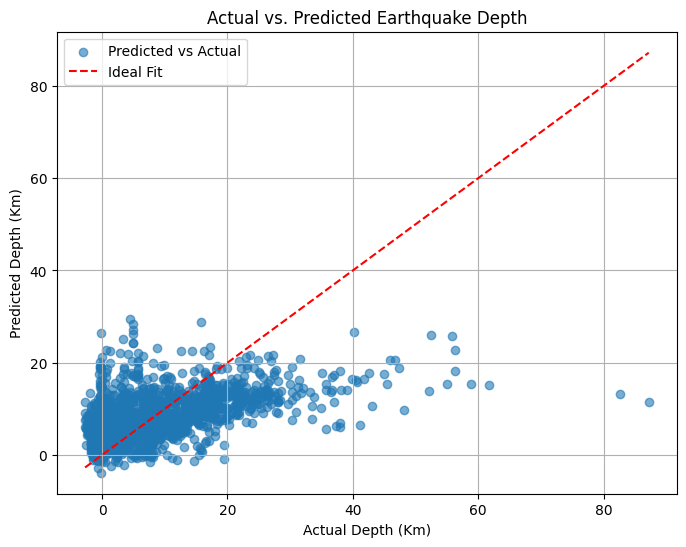

In [54]:
# Actual vs. Predicted Scatter Plot
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.6, label='Predicted vs Actual')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='Ideal Fit')
plt.xlabel("Actual Depth (Km)")
plt.ylabel("Predicted Depth (Km)")
plt.title("Actual vs. Predicted Earthquake Depth")
plt.legend()
plt.grid(True)
plt.show()

### Residual Plot

Evaluate the performance and assumptions about the model. Rsiduals is the actual depth minus - predicted depth. Each dot represents one prediction error. The red line represents zero residual or a perfect prediction.

### Ideal Residual Pattern

Residuals should be randomly scattered around the red or zero line and should not be curved.

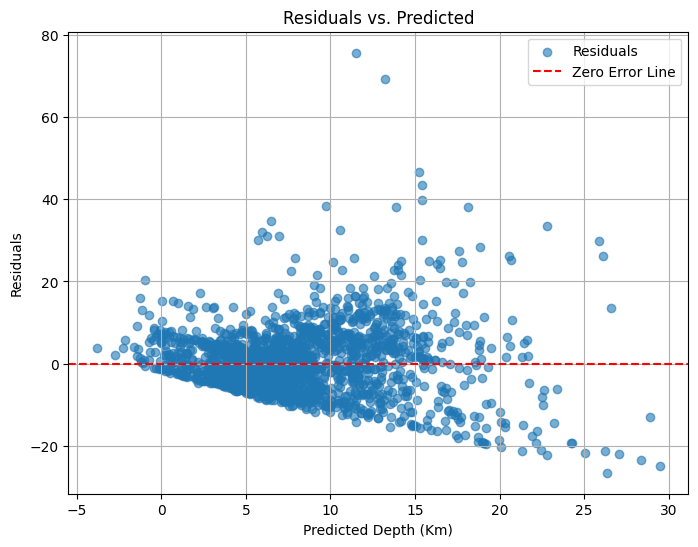

In [55]:
# Residual Plot - Helps Detect Bias
residuals = y_test - y_pred

plt.figure(figsize=(8, 6))
plt.scatter(y_pred, residuals, alpha=0.6, label='Residuals')
plt.axhline(0, color='red', linestyle='--', label='Zero Error Line')
plt.xlabel("Predicted Depth (Km)")
plt.ylabel("Residuals")
plt.title("Residuals vs. Predicted")
plt.legend()
plt.grid(True)
plt.show()

### Prediction Error Distribution

The prediction error distribution plot is informing stakeholders how well the mode is performing by showing the spread and shape of residuals - the difference between actual and predicted earthquake depths.

### Ideal Error Distribution

Should be centered around the zero with indicates the model is unbiased, meaning errors are equally likely to be positive or negative. Symmetrical bell shape suggests a normal distribution of errors.

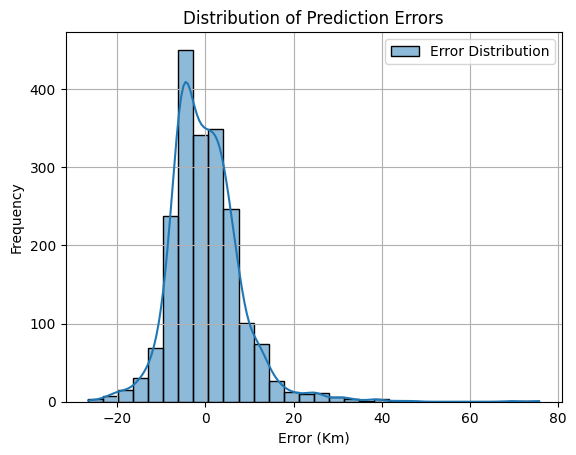

In [56]:
# Prediction Error Distribution - Spot outliers
sns.histplot(residuals, kde=True, bins=30, label='Error Distribution')
plt.title("Distribution of Prediction Errors")
plt.xlabel("Error (Km)")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.show()

### Time-Based Prediction Plot

The time based prediction plot is showing how well the model tracks earthquake depth over time. It is a effective way to detect drift and spot prediction gaps.

### Ideal time-based prediction

Actual and predicted lines should be closley aligned over time, and there should be no sudden divergence which means the model is stable and is not overfitting

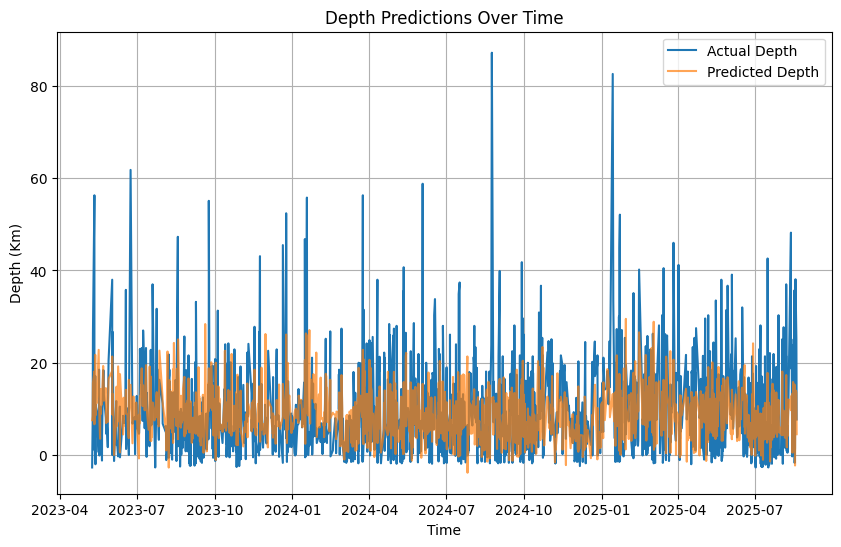

In [57]:
# Time-Based Prediction Plot
df_results = X_test.copy()
df_results['Actual'] = y_test
df_results['Predicted'] = y_pred
df_results['Epoch'] = df.loc[X_test.index, 'Epoch(UTC)']

df_results.sort_values('Epoch', inplace=True)

plt.figure(figsize=(10, 6))
plt.plot(df_results['Epoch'], df_results['Actual'], label='Actual Depth')
plt.plot(df_results['Epoch'], df_results['Predicted'], label='Predicted Depth', alpha=0.7)
plt.title("Depth Predictions Over Time")
plt.xlabel("Time")
plt.ylabel("Depth (Km)")
plt.legend()
plt.grid(True)
plt.show()

### Random Forest Model

Shows which features are most important in the model.

### Ideal Model

The longest bars from left to right are the most important features. In this case longititud and latitude are themost important features.

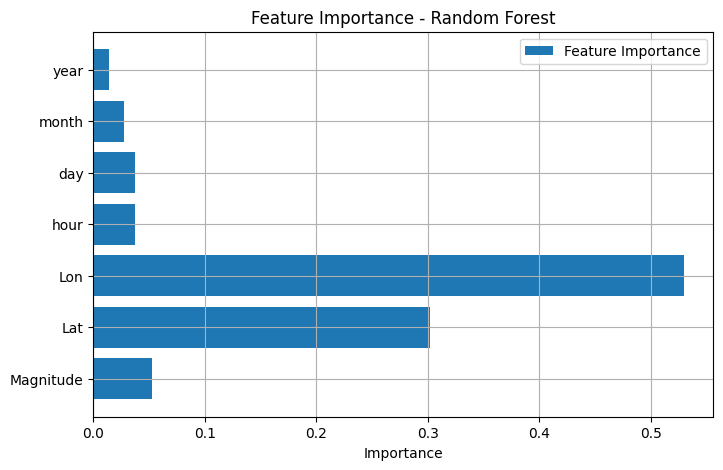

In [58]:
# Visualize feature importance to determine which features influence the predictions.
rf = RandomForestRegressor(random_state=42)
rf.fit(X_train, y_train)

importances = rf.feature_importances_
features = X_train.columns

plt.figure(figsize=(8, 5))
plt.barh(features, importances, label='Feature Importance')
plt.title("Feature Importance - Random Forest")
plt.xlabel("Importance")
plt.legend()
plt.grid(True)
plt.show()

### Compare Models

Compare models by using the R² score and root mean squared error. R² measures how well the model fits the data with 1 being a perfect fit. Root mean squared error measures absolute average error. The lower the value indicates a better predictive performance.
* Linear
* Random Forest
* Gradient Boosting

In [59]:
# Compare models and evaluate performance of three different
# regression algorithms for earthquake prediction task.

# Dictionary of models
models = {
    'Linear': LinearRegression(),
    'Random Forest': RandomForestRegressor(random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42)
}

# Train and evaluate each model and Compare RMSE score of each model.
# The lower score means the models predictions are closer to the actual values.
for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    rmse = root_mean_squared_error(y_test, preds)
    print(f"{name} RMSE: {rmse:.2f}")
    print(f"{name} R² Score:", r2_score(y_test, preds))

Linear RMSE: 8.14
Linear R² Score: 0.2451539653561956
Random Forest RMSE: 5.67
Random Forest R² Score: 0.6342632358549829
Gradient Boosting RMSE: 6.18
Gradient Boosting R² Score: 0.5653432004174112


### Perform hyperparameter tuning for a RandomForestRegressor using GridSearchCV.
This is a systematic way to find the best combination of model settings for predicting earthquake depth.
Will optimize model accuracey without overfitting.

In [60]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5]
}

# Preform exhustive ssearch over param_grid using 5-fold cross-validation
# to evaluate each combination.
grid_search = GridSearchCV(
    RandomForestRegressor(random_state=42),
    param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

# Train and evaluation model configurations using cross-validation above.
grid_search.fit(X_train, y_train)

# Find the one with the lowest RMSE across all folds.
print("Best Parameters:", grid_search.best_params_)

Best Parameters: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 200}


### RMSE vs Hyperparameters

Visualize how the number of trees affects model performance, specifically the cross-validated RMSE

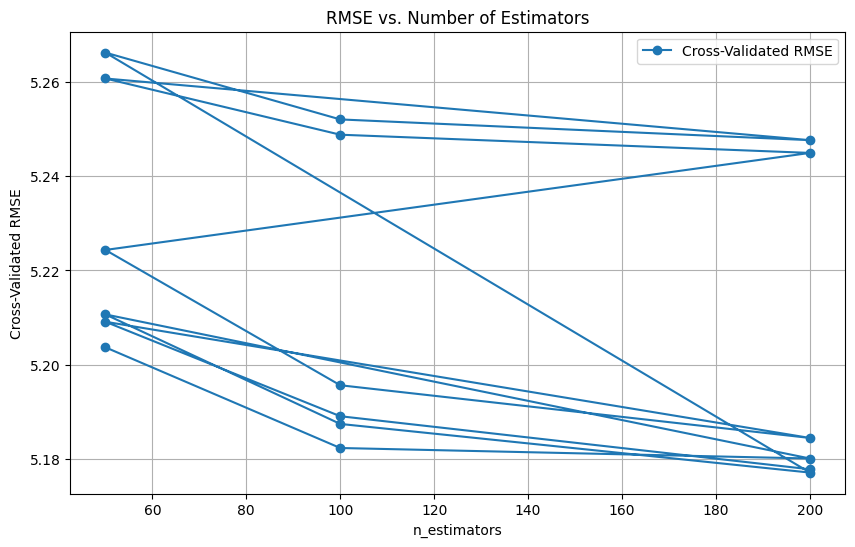

In [61]:
results = pd.DataFrame(grid_search.cv_results_)
plt.figure(figsize=(10, 6))
plt.plot(results['param_n_estimators'], -results['mean_test_score'], marker='o', label='Cross-Validated RMSE')
plt.title("RMSE vs. Number of Estimators")
plt.xlabel("n_estimators")
plt.ylabel("Cross-Validated RMSE")
plt.grid(True)
plt.legend()
plt.show()

### Heatmap of RMSE for GridSearch


Generate heatmap visualization to analyze how different combinations of max_depth and n_estimators affect the models cross-validated RMSE during hyperparameter tuning with GridSearchCV

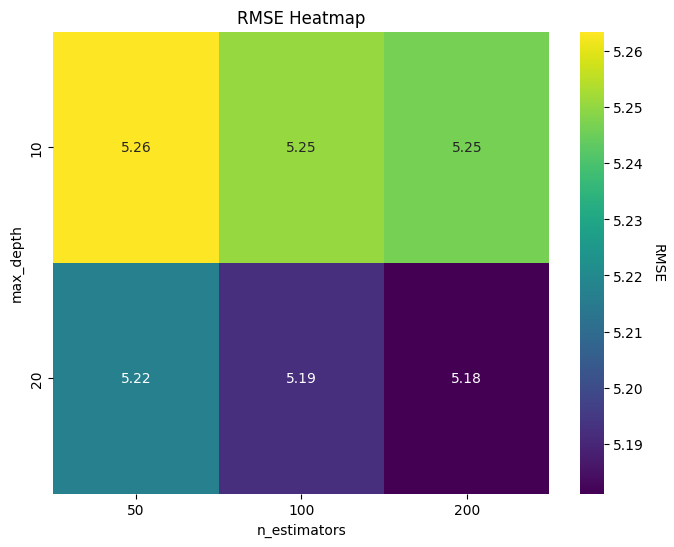

In [62]:
pivot_table = results.pivot_table(
    values='mean_test_score',
    index='param_max_depth',
    columns='param_n_estimators',
    aggfunc='mean'
)

plt.figure(figsize=(8, 6))
ax = sns.heatmap(-pivot_table, annot=True, fmt=".2f", cmap="viridis", cbar=True)
plt.title("RMSE Heatmap")
plt.xlabel("n_estimators")
plt.ylabel("max_depth")

colorbar = ax.collections[0].colorbar
colorbar.set_label("RMSE", rotation=270, labelpad=15)

plt.show()

### Perform Hyperparameter tuning using RandomizedSearchCV


Perform hyperparameter tuning for a RandomForestRegressor using RandomizedSearchCV. Searches for the best combination of model settings to minimize prediction error.

In [63]:
param_dist = {
    'n_estimators': randint(50, 300),
    'max_depth': [None] + list(range(5, 25)),
    'min_samples_split': randint(2, 10)
}

# Samples 20 random combinations from the parameter space 
random_search = RandomizedSearchCV(
    RandomForestRegressor(random_state=42),
    param_distributions=param_dist,
    n_iter=20,
    cv=5,
    scoring='neg_root_mean_squared_error',
    random_state=42,
    n_jobs=-1
)

# Train and evaluation models
random_search.fit(X_train, y_train)

# Return compination with the lowest average RMSE score across all folds.
print("Best Parameters:", random_search.best_params_)

Best Parameters: {'max_depth': 24, 'min_samples_split': 8, 'n_estimators': 171}


# Polynomial Regression Model 

#### Use Standardization and Polynomial Expansion

Prepare feature matrix for a regression model that predicts earthquake depth by apply two key preprocessing steps:
* standardization
* polynomial expansion

The polynomial regression model uses non-linear relationships between earthquake depth and geophysical features like magnitude, latitude, and longitude. The matters for the below reasons:

1. Captures nonlinear features - earthquake depth is influenced by complex tectonic interactions
2. Improves Fit Without Switching to Ensembles - can avoid the complexity of tree-based models and still performs better than linear regression
3. Better RMSE and R²

In [65]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
print(X_scaled)

poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X_scaled)
print(X_poly)

[[-0.7471355   0.24795683 -0.14408099 ...  0.45300675  0.47057796
   1.14328608]
 [-0.88405123  0.31956401 -0.13800192 ...  0.45300675  0.47057796
   1.14328608]
 [ 0.75893763 -0.20524593  1.66241488 ...  0.45300675  0.47057796
   1.14328608]
 ...
 [ 0.48510615  0.83145182 -0.25173112 ... -0.72284008 -0.57771333
  -1.46249417]
 [-1.15788271  0.28044065 -0.0207266  ... -0.72284008 -0.57771333
  -1.46249417]
 [ 0.21127468 -0.53893681 -0.50375908 ... -0.84042477 -0.57771333
  -1.46249417]]
[[-0.7471355   0.24795683 -0.14408099 ...  0.22144362  0.53800524
   1.30710307]
 [-0.88405123  0.31956401 -0.13800192 ...  0.22144362  0.53800524
   1.30710307]
 [ 0.75893763 -0.20524593  1.66241488 ...  0.22144362  0.53800524
   1.30710307]
 ...
 [ 0.48510615  0.83145182 -0.25173112 ...  0.33375269  0.84490238
   2.13888918]
 [-1.15788271  0.28044065 -0.0207266  ...  0.33375269  0.84490238
   2.13888918]
 [ 0.21127468 -0.53893681 -0.50375908 ...  0.33375269  0.84490238
   2.13888918]]


In [66]:
# Split the data and train the model
X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

# Make Predictions
y_pred = model.predict(X_test)
print(y_pred)

[ 7.06675706  4.75568045  3.84128931 ...  7.22178999  7.78451935
 -0.52112215]


In [67]:
# Evaluate performance using RMSE and R²
rmse = root_mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse:.2f}")
print(f"R² Score: {r2:.2f}")

RMSE: 7.88
R² Score: 0.29


## Visualize The Predictions & Performace Using The Same Metrics as Linear Regression Models

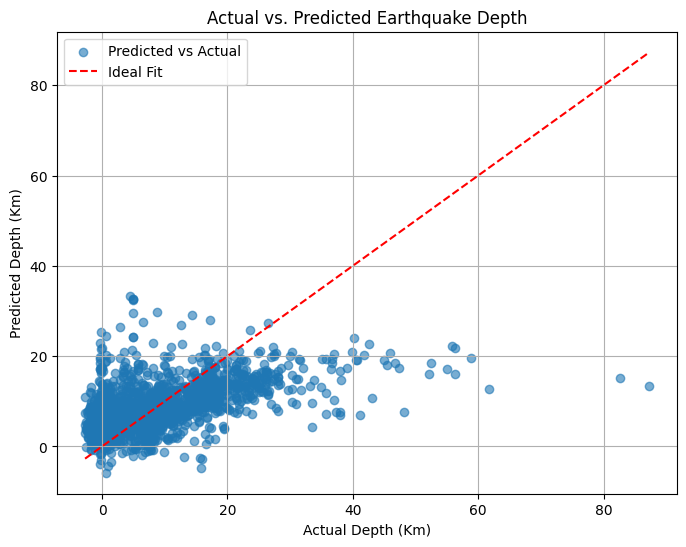

In [68]:
# Actual vs. Predicted Scatter Plot
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.6, label='Predicted vs Actual')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='Ideal Fit')
plt.xlabel("Actual Depth (Km)")
plt.ylabel("Predicted Depth (Km)")
plt.title("Actual vs. Predicted Earthquake Depth")
plt.legend()
plt.grid(True)
plt.show()

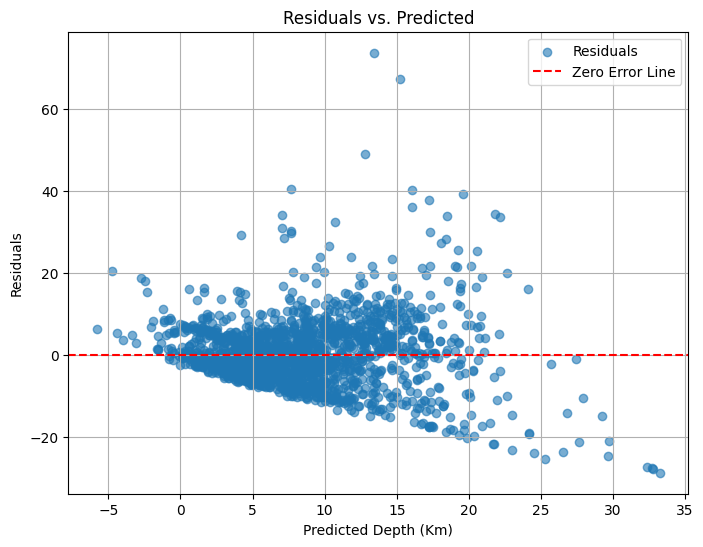

In [69]:
# Residual Plot - Helps Detect Bias
residuals = y_test - y_pred

plt.figure(figsize=(8, 6))
plt.scatter(y_pred, residuals, alpha=0.6, label='Residuals')
plt.axhline(0, color='red', linestyle='--', label='Zero Error Line')
plt.xlabel("Predicted Depth (Km)")
plt.ylabel("Residuals")
plt.title("Residuals vs. Predicted")
plt.legend()
plt.grid(True)
plt.show()

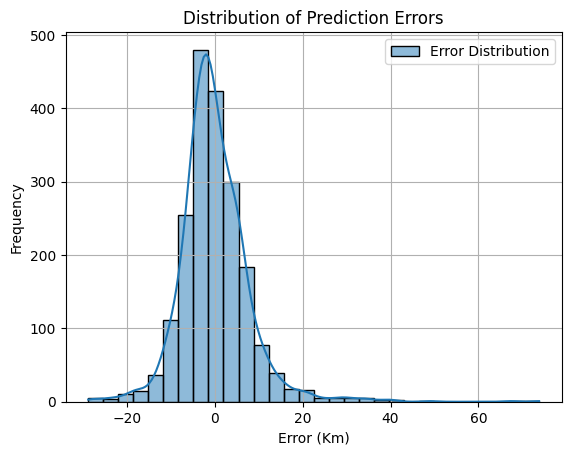

In [70]:
# Prediction Error Distribution - Spot outliers
sns.histplot(residuals, kde=True, bins=30, label='Error Distribution')
plt.title("Distribution of Prediction Errors")
plt.xlabel("Error (Km)")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.show()

## Results

The Actual vs Predicted scatter plot, Residual plot, and Prediction Error Distribution are similar between the Polynominal Model and Linear Models. However, the Polynominal model shows lower RMSE and higher R² score which indicates improved accuracy and variance explanation. 